In [2]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os 

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

This code using the os and tqdm modules to iterate through a directory structure, which is likely a file system, and extract file paths for each file it finds. It is then appending those file paths to a list called data in the end of this cell we will have a list content the path of image like /content/12751/1/12751_idx5_x2301_y1201_class1.png now lets expliend the code.


*   from `tqdm.notebook import tqdm`: This line imports the tqdm function from the tqdm.notebook module, which is a library that provides a progress bar for loops. This function will be used later in the code to show the progress of the loop as it iterates through the directory structure.
*   `base = 'content/'`: This line sets the value of the base variable to a string that represents a file path. This file path appears to be a directory containing subdirectories and files related to breast histopathology images.

*   `ids = os.listdir(base)`: This line uses the listdir function from the os module to retrieve a list of all the items (files and subdirectories) in the directory specified by the base variable. This list is stored in the ids variable.
*   `data = []`: This line initializes an empty list called data, which will be used to store the file paths that are extracted from the directory structure.

*   `for id in tqdm(ids):`: This line starts a for loop that will iterate through each item in the ids list. The tqdm function is used to create a progress bar that shows the progress of the loop as it runs.
*   `files1 = os.listdir(base + id + '/1/')`: This line uses the listdir function to retrieve a list of all the items in the subdirectory base/id/1/, where id is the current item being iterated over in the loop. This list is stored in the files1 variable.

*   `files0 = os.listdir(base + id + '/0/')`: This line is similar to the previous line
*   `for x in files1:`: This line starts a nested for loop that iterates through each item in the files1 list.


*   `data.append(base + id + '/1/' + x)`: This line uses the append method to add the file path base/id/1/x to the data list, where x is the current item being iterated over in the nested loop.












In [4]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

base = '/content/'

ids = os.listdir(base)

data = []
for id in tqdm(ids):
  try:
    files1 = os.listdir(base + id + '/1/')
    
    files0 = os.listdir(base + id + '/0/')
    for x in files1:
      data.append(base + id + '/1/' + x)
    for x in files0:
      data.append(base + id + '/0/' + x)
  except:
    FileNotFoundError
len(data)
print(data[0])


  0%|          | 0/283 [00:00<?, ?it/s]

/content/12751/1/12751_idx5_x2301_y1201_class1.png


This cell shuffling the elements in the data list and then selecting the first 20,000 elements from the shuffled list we do that for 2 reason :

1.   the data now will be more likely to be representative of the full dataset
2.    This can help prevent the model from learning patterns in the data that are due to the order of the data rather than the underlying relationships between the features and the target variable.




*   `random.shuffle(data)`: This line uses the shuffle function from the random module to randomly shuffle the elements in the data list.
*   `data = data[:20000]`: This line uses list slicing to select the first 20,000 elements from the data list and assigns them to the data variable. The resulting data variable will now contain the first 20,000 elements from the original data list, but in a randomly shuffled order.



In [6]:
import random

random.shuffle(data)
data = data[:20000]
len(data)

20000

This cell reading in a list of image file paths (stored in the `data` variable) and extracting the corresponding images and labels from those file paths. Here's a breakdown of what each line does:


*  `from tqdm.notebook import tqdm`: This line imports the tqdm function from the tqdm.notebook module. This function is used to create a progress bar that displays the progress of the loop that follows.

*   `import keras_preprocessing.image as IMAGE `: This line imports the image module from the keras_preprocessing library and assigns it to the alias IMAGE. This module provides functions for preprocessing images for use in machine learning models.

*   `images=[]`: This line initializes an empty list called images, which will be used to store the extracted images.
*   `labels=[]`: This line initializes an empty list called labels, which will be used to store the labels for the extracted images.


*   `for i in tqdm(data):`: This line starts a loop that iterates over each
element in the `data`


*   `label = int(i[-5])`: This line extracts the label for the current image from the file path stored in the i variable. The label is determined by the fifth character from the end of the file path, which is converted to an integer using the int function.


*  ` img = IMAGE.img_to_array(IMAGE.load_img(i, target_size=(50, 50)))`: This line uses the load_img function from the IMAGE module to load the image file stored at the file path i. The target_size argument specifies that the image should be resized to a 50x50 pixel image. The img_to_array function is then used to convert the image to a NumPy array. The resulting array is stored in the img variable.
*   `images.append(img)`: This line adds the image stored in the img variable to the images list.
*  `labels.append(label)`: This line adds the label stored in the label variable to the labels list.`




In [7]:

from tqdm.notebook import tqdm
import keras_preprocessing.image as IMAGE


images=[]
labels=[]

for i in tqdm(data):
  label = int(i[-5])
  img = IMAGE.img_to_array(IMAGE.load_img(i, target_size=(50, 50)))
  images.append(img)
  labels.append(label)

  0%|          | 0/20000 [00:00<?, ?it/s]

This cell scale the input data to a range (0-1) then splitting the images and labels into training and test sets. Here's a breakdown of what each line does:


*   `from sklearn.model_selection import train_test_split`: This line imports the train_test_split function from the model_selection module in the sklearn library. This function is used to split a dataset into training and test sets.

*  `y = np.array(labels)`: This line converts the labels list to a NumPy array and assigns the result to the y variable.

* ` x = np.stack(images)/255`: This line converts the images list to a NumPy array using the stack function, and then divides the resulting array by 255 to scale the pixel values to the range 0-1. The resulting array is assigned to the x variable.

*   `x_train,x_test,y_train,y_test = train_test_split(x, y, random_state=0, test_size=0.3)`: This line uses the train_test_split function to split the x and y arrays into training and test sets. The random_state argument specifies a seed for the random number generator that is used to shuffle the data before splitting it. The test_size argument specifies the fraction of the data that should be assigned to the test set (in this case, 30%). The resulting training and test sets are assigned to the x_train, x_test, y_train, and y_test variables, respectively.




In [8]:
from sklearn.model_selection import train_test_split

y = np.array(labels)
x = np.stack(images)/255

x_train,x_test,y_train,y_test = train_test_split(x, y, random_state=42, test_size=0.3, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(14000, 50, 50, 3) (6000, 50, 50, 3) (14000,) (6000,)


This cell is using the matplotlib library to plot a grid of images and their corresponding labels. Here's a breakdown of what each line does:


*   `sample_images = x_train[:9]`: This line selects the first 9 images from the training set and assigns them to the sample_images variable.

*  `sample_labels = y_train[:9]`: This line selects the first 9 labels from the training set and assigns them to the sample_labels variable.
*  `fig, axs = plt.subplots(3, 3, figsize=(10, 10))`: This line creates a figure with 3 rows and 3 columns of subplots, and sets the size of the figure to 10x10 inches. The fig variable is assigned the Figure object, and the axs variable is assigned a 2D array of Axes objects representing the subplots.


*   `for i, ax in enumerate(axs.flat):`: This line loops over the Axes objects in the axs array. The enumerate function adds an index to the loop, which is assigned to the i variable. The ax variable is assigned the current Axes object.



*   `ax.imshow(sample_images[i])`: This line plots the i-th image in the sample_images array on the i-th subplot.

*   `ax.set_title(f"Label: {sample_labels[i]}", fontsize=14)`: This line sets the title of the i-th subplot to the i-th label in the sample_labels array. The f string syntax is used to format the string, with the sample_labels[i] value being inserted into the string. The fontsize argument sets the size of the title text.
* ` ax.axis('off')`: This line hides the axis labels and ticks on the i-th subplot.







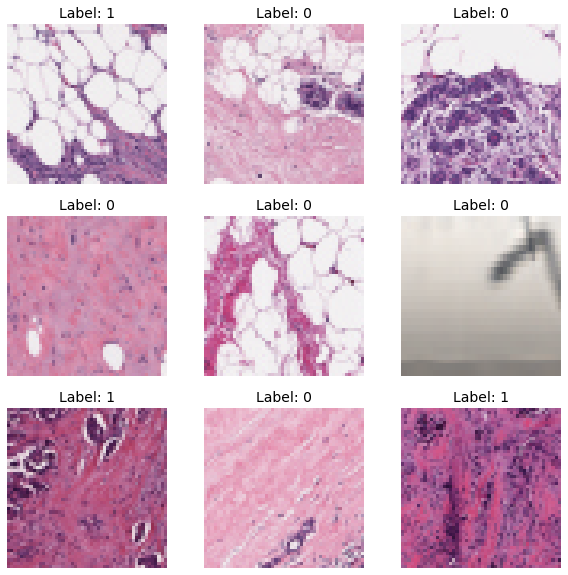

In [11]:
#visualise training examples
sample_images = x_train[:9]
sample_labels = y_train[:9]

# Set up the subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Plot the sample images
for i, ax in enumerate(axs.flat):
    ax.imshow(sample_images[i])
    ax.set_title(f"Label: {sample_labels[i]}", fontsize=14)
    ax.axis('off')

# Show the plot
plt.show()

This cell defines a CNN model with several convolutional and max pooling layers, as well as dropout and fully-connected layers. The model takes images of size 50x50x3 as input and outputs a single sigmoid value, which represents the probability that the input image belongs to the positive class (in this case, the class representing breast cancer).

The model is compiled with the binary cross-entropy loss function and the Adam optimizer, and the model's accuracy is tracked during training. Once the model is trained and evaluated, the summary can be used to understand the model's architecture and the metrics can be used to assess the model's performance.

*   `model=Sequential()`: This line creates a new instance of the Sequential model from the keras library and assigns it to the model variable. The Sequential model is a type of model that allows you to stack layers in a linear fashion, with the output of one layer being the input of the next.

*   `model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))`: This line adds a 2D convolutional layer to the model. The Conv2D layer applies a convolution operation to the input data, which can help the model learn spatial relationships between the pixels in the image. The filters argument specifies the number of filters to use in the convolutional layer, and the kernel_size argument specifies the size of the filters. The input_shape argument specifies the shape of the input data, and the activation argument specifies the activation function to use. In this case, the activation function is the rectified linear unit (ReLU) function, which returns the input if it is positive and returns 0 if it is negative.

*  ` model.add(MaxPool2D(pool_size=(2,2)))`: This line adds a 2D max pooling layer to the model. The MaxPool2D layer applies max pooling to the input data, which reduces the spatial dimensions of the data by taking the maximum value within each pooling window. The pool_size argument specifies the size of the pooling window.

*   `model.add(Dropout(0.25))`: This line adds a dropout layer to the model. The Dropout layer randomly sets a fraction of the input units to 0 at each update during training, which can help prevent overfitting. The rate argument specifies the fraction of the units to drop.


*  `model.add(Flatten())`: This line adds a flatten layer to the model. The Flatten layer flattens the input data into a 1D array, which is necessary before passing the data to a fully-connected layer.

*   `model.add(Dense(64,activation='relu'))`: This line adds a fully-connected (dense) layer to the model. The Dense layer applies a linear transformation to the input data using a set of weights and biases. The units argument specifies the number of units in the layer, and the activation argument specifies the activation function to use. In this case, the activation function is the ReLU function.

*  ` model.add(Dense(1,activation='sigmoid'))`: This line adds another fully-connected layer to the model, but this time the output layer has only one unit and uses the sigmoid activation function. The sigmoid activation function maps the input values to the range 0-1, which is useful for binary classification tasks like this one.

*   `model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= ['accuracy'])`: This line compiles the model, specifying the loss function to use, the optimizer to use, and the metrics to track. The loss argument specifies the binary cross-entropy loss function, which is a common choice for binary classification tasks. The optimizer argument specifies the Adam optimizer, which is a gradient-based optimization algorithm The metrics argument specifies the metrics that the model should track during training and evaluation

* ` model.summary()`: This line prints a summary of the model, including the number of parameters in each layer and the shape of the output of each layer. This can be useful for understanding the architecture of the model and for debugging purposes.






In [9]:
from tensorflow.keras import regularizers

model=Sequential()

model.add(Conv2D(filters=20,kernel_size=(3,3),input_shape=(50,50,3),activation='relu'))
model.add(Conv2D(filters=20,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=20,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=40,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=40,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=40,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=80,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=80,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=80,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 20)        560       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 20)        3620      
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 20)        3620      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 20)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 20)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 40)        7240      
                                                        

This cell is using the fit method of the model object to train the CNN on the training data. Here's a breakdown of what each argument does:


*   `x_train, y_train`: These arguments specify the training data and labels, respectively. The training data is an array of images, and the labels are an array of corresponding binary labels (0 or 1).

*   `validation_data = (x_test, y_test)`: This argument specifies the validation data and labels, which are used to evaluate the model's performance during training. The validation data is an array of images, and the labels are an array of corresponding binary labels.

*   `epochs = 100`: This argument specifies the number of epochs to train the model for. An epoch is a single pass through the entire training set.
* ` verbose = 2`: This argument specifies the level of verbosity of the training process. Setting verbose=2 causes the model to print one line per epoch with the loss and accuracy values for both the training and validation sets.


*  ` batch_size = 256`: This argument specifies the batch size to use during training. The batch size determines the number of training examples to use in each gradient update.

The fit method returns a History object that contains information about the training process, including the loss and accuracy values for each epoch. The history variable is assigned the History object returned by the fit method.



In [119]:
import tensorflow as tf

history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 256 )

Epoch 1/100
55/55 [==============================] - 4s 53ms/step - loss: 10.1978 - accuracy: 0.7171 - val_loss: 5.6410 - val_accuracy: 0.7793
Epoch 2/100
55/55 [==============================] - 3s 47ms/step - loss: 3.0735 - accuracy: 0.8029 - val_loss: 1.1774 - val_accuracy: 0.8000
Epoch 3/100
55/55 [==============================] - 3s 47ms/step - loss: 0.6877 - accuracy: 0.8071 - val_loss: 0.5072 - val_accuracy: 0.8200
Epoch 4/100
55/55 [==============================] - 3s 46ms/step - loss: 0.5053 - accuracy: 0.8181 - val_loss: 0.4800 - val_accuracy: 0.8182
Epoch 5/100
55/55 [==============================] - 3s 47ms/step - loss: 0.4902 - accuracy: 0.8224 - val_loss: 0.4900 - val_accuracy: 0.8163
Epoch 6/100
55/55 [==============================] - 3s 47ms/step - loss: 0.4881 - accuracy: 0.8215 - val_loss: 0.4631 - val_accuracy: 0.8290
Epoch 7/100
55/55 [==============================] - 3s 47ms/step - loss: 0.4748 - accuracy: 0.8256 - val_loss: 0.4576 - val_accuracy: 0.8300
Epoch

This cell defines a function called predict that takes a model and a test data set as input and returns the model's predictions on the test data. Here's a breakdown of what each line does:


*  ` predictions = model.predict(test_data)`: This line uses the predict method of the model object to make predictions on the test_data. The predict method returns an array of probability values between 0 and 1, where values close to 0 correspond to a prediction of class 0 and values close to 1 correspond to a prediction of class 1.
* ` rounded_predictions = np.round(predictions)`: This line rounds the probability values to 0 or 1 using the round function from the numpy library.



In [ ]:
def predict(model, test_data):
    # Make predictions on the test data
    predictions = model.predict(test_data)
    # Round the predictions to 0 or 1
    rounded_predictions = np.round(predictions)
    return rounded_predictions
predictions = predict(model, x_test)


188/188 [==============================] - 1s 4ms/step


Enter the index of the sample to plot from(0 - 5999): 2000


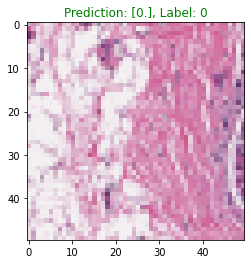

In [ ]:
sample_index = int(input("Enter the index of the sample to plot from(0 - 5999): "))
sample = x_test[sample_index ]
prediction = predictions[sample_index ]
label = y_test[sample_index ]

# Plot the sample and the prediction and label
plt.imshow(sample)
if prediction == label:
    color = 'green'
else:
    color = 'red'

plt.title(f"Prediction: {prediction}, Label: {label}", color=color)
plt.show()

This cell is using the matplotlib library to plot the training and validation accuracy curves for the CNN model. Here's a breakdown of what each line does:


*  `plt.plot(history.history['accuracy'])`: This line plots the training accuracy values stored in the history object. The history object is a dictionary that contains the training and validation metrics for each epoch. The history['accuracy'] key returns a list of the training accuracy values for each epoch.

*   `plt.plot(history.history['val_accuracy'])`: This line plots the validation accuracy values stored in the history object. The history['val_accuracy'] key returns a list of the validation accuracy values for each epoch.
* ` plt.title('model accuracy')`: This line sets the title of the plot to 'model accuracy'.

* `plt.legend(['train', 'val'], loc='upper left')`: This line adds a legend to 
the plot, indicating which curve corresponds to the training accuracy and which curve corresponds to the validation accuracy. The loc argument specifies the location of the legend on the plot.

*   plt.show(): This line displays the plot.





In [1]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

This cell is using the matplotlib library to plot the training and validation loss curves for the CNN model

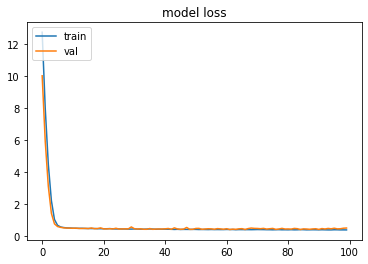

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

This code defines a new neural network model using the Sequential class from the keras library. The model has several fully-connected (dense) layers and a dropout layer. Here's a breakdown of what each line does:


* ` model_2 = Sequential()`: This line creates a new Sequential model and assigns it to the model_2 variable.

*  ` model_2.add(Flatten(input_shape=(50, 50, 3)))`: This line adds a Flatten layer to the model. The Flatten layer flattens the input tensor, which has shape (50, 50, 3), into a 1D tensor of shape (4500,). The input_shape argument specifies the shape of the input tensor.
* ` model_2.add(Dense(64, activation='relu'))`: This line adds a fully-connected (dense) layer to the model with 64 units and the ReLU activation function.


*  ` model_2.add(Dropout(0.2))`: This line adds a dropout layer to the model with a rate of 0.2. The dropout layer randomly sets a fraction of the input units to zero during training, which helps to prevent overfitting.


*  ` model_2.add(Dropout(0.2))`: This line adds a dropout layer to the model with a rate of 0.2. The dropout layer randomly sets a fraction of the input units to zero during training, which helps to prevent overfitting.
*   `model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])`: This line compiles the model, specifying the binary cross-entropy loss function, the Adam optimizer, and the accuracy metric.




In [55]:
model_2=Sequential()
model_2.add(Flatten(input_shape=(50,50,3)))
model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.34))
model_2.add(Dense(64,activation='relu'))
model_2.add(Dense(32,activation='relu'))
model_2.add(Dropout(0.35))
model_2.add(Dense(1,activation='sigmoid'))
model_2.compile(loss = 'binary_crossentropy', optimizer ='adamax', metrics= ['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7500)              0         
                                                                 
 dense (Dense)               (None, 128)               960128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [56]:
import tensorflow as tf
tf.keras.backend.clear_session()
history_2 = model_2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, verbose = 2, batch_size = 256)

Epoch 1/100
55/55 - 1s - loss: 0.7765 - accuracy: 0.6635 - val_loss: 0.5819 - val_accuracy: 0.7108 - 1s/epoch - 24ms/step
Epoch 2/100
55/55 - 0s - loss: 0.5857 - accuracy: 0.7076 - val_loss: 0.5688 - val_accuracy: 0.7108 - 446ms/epoch - 8ms/step
Epoch 3/100
55/55 - 0s - loss: 0.5755 - accuracy: 0.7124 - val_loss: 0.5527 - val_accuracy: 0.7108 - 461ms/epoch - 8ms/step
Epoch 4/100
55/55 - 0s - loss: 0.5579 - accuracy: 0.7136 - val_loss: 0.5328 - val_accuracy: 0.7108 - 436ms/epoch - 8ms/step
Epoch 5/100
55/55 - 0s - loss: 0.5351 - accuracy: 0.7161 - val_loss: 0.5135 - val_accuracy: 0.7108 - 462ms/epoch - 8ms/step
Epoch 6/100
55/55 - 0s - loss: 0.5160 - accuracy: 0.7200 - val_loss: 0.4990 - val_accuracy: 0.7232 - 473ms/epoch - 9ms/step
Epoch 7/100
55/55 - 0s - loss: 0.5003 - accuracy: 0.7410 - val_loss: 0.4757 - val_accuracy: 0.7485 - 486ms/epoch - 9ms/step
Epoch 8/100
55/55 - 0s - loss: 0.4865 - accuracy: 0.7631 - val_loss: 0.4693 - val_accuracy: 0.7677 - 442ms/epoch - 8ms/step
Epoch 9/10

In [14]:
def predict(model, test_data):
    # Make predictions on the test data
    predictions = model.predict(test_data)
    # Round the predictions to 0 or 1
    rounded_predictions = np.round(predictions)
    return rounded_predictions
predictions = predict(model_2, x_test)


188/188 [==============================] - 0s 2ms/step


Enter the index of the sample to plot from(0 - 6000): 34


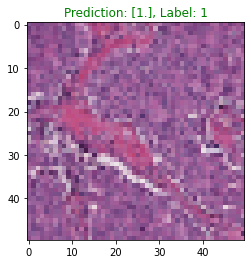

In [16]:
sample_index = int(input("Enter the index of the sample to plot from(0 - 6000): "))
sample = x_test[sample_index ]
prediction = predictions[sample_index ]
label = y_test[sample_index ]

# Plot the sample and the prediction and label
plt.imshow(sample)
if prediction == label:
    color = 'green'
else:
    color = 'red'
plt.title(f"Prediction: {prediction}, Label: {label}", color=color)
plt.show()

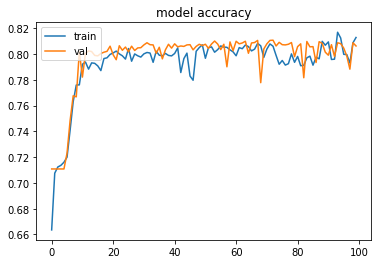

In [61]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

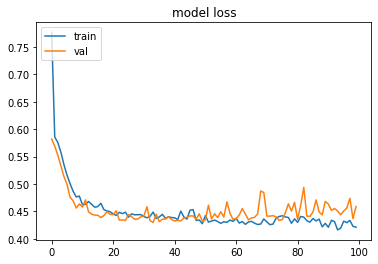

In [62]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()